# Installing Dependencies

In [1]:
!pip install -q keras

In [2]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm import tqdm
import pickle
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt
from scipy.spatial.distance import cdist
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from tensorflow.keras.callbacks import *
from keras import backend as K
import keras
import tensorflow as tf

2024-05-10 16:39:52.280554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 16:39:52.280668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 16:39:52.407957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Helper Functions

In [3]:
# Temple resizing function
import numpy as np
import os
import pandas as pd
import random
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist

###################################################################################
#Rescale to be 64 frames
def zoom(p,target_l=64,joints_num=25,joints_dim=3):
    l = p.shape[0]
    p_new = np.empty([target_l,joints_num,joints_dim])
    for m in range(joints_num):
        for n in range(joints_dim):
            p[:,m,n] = medfilt(p[:,m,n],3)
            p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
    return p_new

def sampling_frame(p,C):
    full_l = p.shape[0] # full length
    if random.uniform(0,1)<0.5: # aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        s = random.randint(0, full_l-int(valid_l))
        e = s+valid_l # sample end point
        p = p[int(s):int(e),:,:]
    else: # without aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        index = np.sort(np.random.choice(range(0,full_l),int(valid_l),replace=False))
        p = p[index,:,:]
    p = zoom(p,C.frame_l,C.joint_n,C.joint_d)
    return p

def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast

def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,1,C.joint_n)
    for f in range(C.frame_l):
        #distance max
        d_m = cdist(p[f],np.concatenate([p[f],np.zeros([1,C.joint_d])]),'euclidean')
        d_m = d_m[iu]
        M.append(d_m)
    M = np.stack(M)
    return M

def normlize_range(p):
    # normolize to start point, use the center for hand case
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(8,8)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args:
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                #annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                annot[i, j] = '%.1f' % (p)
            elif c == 0:
                annot[i, j] = ''
            else:
                #annot[i, j] = '%.1f%%\n%d' % (p, c)
                annot[i, j] = '%.1f' % (p)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cbar=False, cmap="YlGnBu")
    plt.savefig(filename)

# Downloading Dataset

In [4]:
!wget https://github.com/fandulu/DD-Net/archive/master.zip
!unzip master.zip
!rm master.zip

--2024-05-10 16:40:03--  https://github.com/fandulu/DD-Net/archive/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fandulu/DD-Net/zip/refs/heads/master [following]
--2024-05-10 16:40:03--  https://codeload.github.com/fandulu/DD-Net/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: 'master.zip'

master.zip              [        <=>         ]  79.09M  14.6MB/s    in 5.4s    

2024-05-10 16:40:08 (14.6 MB/s) - 'master.zip' saved [82934337]

Archive:  master.zip
f26a9994b0bafc41096fa269eab89c2757d71499
   creating: DD-Net-master/
  inflating: DD-Net-master/.gitignore  
   creating: DD-Net-master/JHMDB/

# Setting up configuration and Making Dataset

In [33]:
random.seed(1234)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
#         self.joint_n = 12 # the number of joints
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 64

C = Config()

Train = pickle.load(open("/kaggle/working/DD-Net-master/data/SHREC/train.pkl", "rb"))
Test = pickle.load(open("/kaggle/working/DD-Net-master/data/SHREC/test.pkl", "rb"))

X_0 = []
X_1 = []
Y = []

for i in tqdm(range(len(Train['pose']))):
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)

    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1

    M = get_CG(p,C)
    
    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)
X_1 = np.stack(X_1)
Y = np.stack(Y)

  0%|          | 0/1960 [00:00<?, ?it/s]/tmp/ipykernel_34/4032415710.py:22: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
100%|██████████| 1960/1960 [00:19<00:00, 99.23it/s] 


In [34]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))):
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)

    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0)
X_test_1 = np.stack(X_test_1)
Y_test = np.stack(Y_test)

  0%|          | 0/840 [00:00<?, ?it/s]/tmp/ipykernel_34/4032415710.py:22: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
100%|██████████| 840/840 [00:08<00:00, 100.30it/s]


In [35]:
# def generate_triplets(data, labels, num_triplets):
#     triplets = []
#     for _ in range(num_triplets):
#         # Select anchor
#         anchor_idx = np.random.randint(0, len(data))
#         anchor = data[anchor_idx]
#         anchor_label = labels[anchor_idx]

#         # Select positive sample
#         positive_candidates = np.where(labels == anchor_label)[0]
#         positive_idx = np.random.choice(positive_candidates)
#         positive = data[positive_idx]

#         # Select negative sample
#         negative_candidates = np.where(labels != anchor_label)[0]
#         negative_idx = np.random.choice(negative_candidates)
#         negative = data[negative_idx]

#         triplets.append((anchor, positive, negative))
#     return triplets

import numpy as np

import numpy as np

def generate_triplets(data, labels, num_triplets):
    triplets = []
    for _ in range(num_triplets):
        # Initialize variables
        anchor = None
        anchor_label = None
        positive = None
        negative = None
        
        # Bias condition
        if np.random.uniform() < 0.2:
            # Choose anchor with label 1
            anchor_candidates = np.where(labels == 1)[0]
            if len(anchor_candidates) == 0:
                continue  # Skip this iteration if no anchor candidates found
            anchor_idx = np.random.choice(anchor_candidates)
            anchor = data[anchor_idx]
            anchor_label = labels[anchor_idx]

            # Choose positive with label 1
            positive_candidates = np.where(labels == 1)[0]
            if len(positive_candidates) == 0:
                continue  # Skip this iteration if no positive candidates found
            positive_idx = np.random.choice(positive_candidates)
            positive = data[positive_idx]

            # Choose negative with label 0
            negative_candidates = np.where(labels == 0)[0]
            if len(negative_candidates) == 0:
                continue  # Skip this iteration if no negative candidates found
            negative_idx = np.random.choice(negative_candidates)
            negative = data[negative_idx]
        elif np.random.uniform() < 0.4:
            # Choose anchor with label 3
            anchor_candidates = np.where(labels == 3)[0]
            if len(anchor_candidates) == 0:
                continue  # Skip this iteration if no anchor candidates found
            anchor_idx = np.random.choice(anchor_candidates)
            anchor = data[anchor_idx]
            anchor_label = labels[anchor_idx]

            # Choose positive with label 3
            positive_candidates = np.where(labels == 3)[0]
            if len(positive_candidates) == 0:
                continue  # Skip this iteration if no positive candidates found
            positive_idx = np.random.choice(positive_candidates)
            positive = data[positive_idx]

            # Choose negative with label 0
            negative_candidates = np.where(labels == 0)[0]
            if len(negative_candidates) == 0:
                continue  # Skip this iteration if no negative candidates found
            negative_idx = np.random.choice(negative_candidates)
            negative = data[negative_idx]
        else:
            # Select anchor randomly
            anchor_idx = np.random.randint(0, len(data))
            anchor = data[anchor_idx]
            anchor_label = labels[anchor_idx]

            # Select positive sample
            positive_candidates = np.where(labels == anchor_label)[0]
            if len(positive_candidates) == 0:
                continue  # Skip this iteration if no positive candidates found
            positive_idx = np.random.choice(positive_candidates)
            positive = data[positive_idx]

            # Select negative sample
            negative_candidates = np.where(labels != anchor_label)[0]
            if len(negative_candidates) == 0:
                continue  # Skip this iteration if no negative candidates found
            negative_idx = np.random.choice(negative_candidates)
            negative = data[negative_idx]

        triplets.append((anchor, positive, negative))
    return triplets


In [36]:
# Create a data generator function to yield triplets one at a time
def trainTripletGeneratorX_1():
    num_triplets = 100000
    triplets = generate_triplets(X_1, Y, num_triplets)
    while True:
        np.random.shuffle(triplets)
        for triplet in triplets:
            yield triplet
            
# Create a data generator function to yield triplets one at a time
def testTripletGeneratorX_1():
    num_triplets = 30000
    triplets = generate_triplets(X_test_1, Y_test, num_triplets)
    while True:
        np.random.shuffle(triplets)
        for triplet in triplets:
            yield triplet

# Create a TensorFlow Dataset
trainTfDatasetX_1 = tf.data.Dataset.from_generator(
    generator=trainTripletGeneratorX_1,
    output_signature=(
        tf.TensorSpec(shape=(32, 22, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(32, 22, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(32, 22, 3), dtype=tf.float32),
    )
)

# Create a TensorFlow Dataset
testTfDatasetX_1 = tf.data.Dataset.from_generator(
    generator=testTripletGeneratorX_1,
    output_signature=(
        tf.TensorSpec(shape=(32, 22, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(32, 22, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(32, 22, 3), dtype=tf.float32),
    )
)

BATCH_SIZE = 256
BUFFER_SIZE = BATCH_SIZE * 2

trainDsX_1 = (trainTfDatasetX_1
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

valDsX_1 = (testTfDatasetX_1
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [37]:
# Create a data generator function to yield triplets one at a time
def trainTripletGeneratorX_0():
    num_triplets = 100000
    triplets = generate_triplets(X_0, Y, num_triplets)
    while True:
        np.random.shuffle(triplets)
        for triplet in triplets:
            yield triplet

# Create a data generator function to yield triplets one at a time
def testTripletGeneratorX_0():
    num_triplets = 30000
    triplets = generate_triplets(X_test_0, Y_test, num_triplets)
    while True:
        np.random.shuffle(triplets)
        for triplet in triplets:
            yield triplet

# Create a TensorFlow Dataset
trainTfDatasetX_0 = tf.data.Dataset.from_generator(
    generator=trainTripletGeneratorX_0,
    output_signature=(
        tf.TensorSpec(shape=(32, 231), dtype=tf.float32),
        tf.TensorSpec(shape=(32, 231), dtype=tf.float32),
        tf.TensorSpec(shape=(32, 231), dtype=tf.float32),
    )
)

# Create a TensorFlow Dataset
testTfDatasetX_0 = tf.data.Dataset.from_generator(
    generator=testTripletGeneratorX_0,
    output_signature=(
        tf.TensorSpec(shape=(32, 231), dtype=tf.float32),
        tf.TensorSpec(shape=(32, 231), dtype=tf.float32),
        tf.TensorSpec(shape=(32, 231), dtype=tf.float32),
    )
)

BATCH_SIZE = 256
BUFFER_SIZE = BATCH_SIZE * 2

trainDsX_0 = (trainTfDatasetX_0
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

valDsX_0 = (testTfDatasetX_0
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Model

In [38]:
class SiameseModel(keras.Model):
    def __init__(self, siameseNetwork, margin, lossTracker):
        super().__init__()
        self.siameseNetwork = siameseNetwork
        self.margin = margin
        self.lossTracker = lossTracker
    def _compute_distance(self, inputs):
        # (anchor, positive, negative) = inputs
        # embed the images using the siamese network
        embeddings = self.siameseNetwork(inputs)
        anchorEmbedding = embeddings[0]
        positiveEmbedding = embeddings[1]
        negativeEmbedding = embeddings[2]
        # calculate the anchor to positive and negative distance
        apDistance = tf.reduce_sum(tf.square(anchorEmbedding - positiveEmbedding), axis=-1)
        anDistance = tf.reduce_sum(tf.square(anchorEmbedding - negativeEmbedding), axis=-1)
        return (apDistance, anDistance)
    def _compute_loss(self, apDistance, anDistance):
        loss = apDistance - anDistance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    def call(self, inputs):
        # compute the distance between the anchor and positive,
        # negative images
        (apDistance, anDistance) = self._compute_distance(inputs)
        return (apDistance, anDistance)
    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            # compute the distance between the anchor and positive,
            # negative images
            (apDistance, anDistance) = self._compute_distance(inputs)
            # calculate the loss of the siamese network
            loss = self._compute_loss(apDistance, anDistance)
        # compute the gradients and optimize the model
        gradients = tape.gradient(
            loss,
            self.siameseNetwork.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.siameseNetwork.trainable_variables)
        )
        # update the metrics and return the loss
        self.lossTracker.update_state(loss)
        return {"loss": self.lossTracker.result()}
    def test_step(self, inputs):
        # compute the distance between the anchor and positive,
        # negative images
        (apDistance, anDistance) = self._compute_distance(inputs)
        # calculate the loss of the siamese network
        loss = self._compute_loss(apDistance, anDistance)

        # update the metrics and return the loss
        self.lossTracker.update_state(loss)
        return {"loss": self.lossTracker.result()}
    @property
    def metrics(self):
        return [self.lossTracker]

In [39]:
def c1D(x, filters, kernel):
    x = Conv1D(filters, kernel_size=kernel, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def get_embedding_moduleX_1_Slow(frame_l=32,feat_d=231, filters=64, joint_n=22, joint_d=3):
    inputs = Input(shape=(frame_l,joint_n,joint_d))
    diff_slow, _ = pose_motion(inputs,frame_l)
    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x = Flatten()(x_d_slow)
    outputs = Dense(units=256)(x)
    embedding = keras.Model(inputs, outputs, name="embedding")
    return embedding

def get_siamese_networkX_1_Slow(embeddingModel, frame_l=32,feat_d=231, filters=64, joint_n=22, joint_d=3):
    # build the anchor, positive and negative input layer
    anchorInput = keras.Input(name="anchor", shape=(frame_l,joint_n,joint_d))
    positiveInput = keras.Input(name="positive", shape=(frame_l,joint_n,joint_d))
    negativeInput = keras.Input(name="negative", shape=(frame_l,joint_n,joint_d))
    # embed the anchor, positive and negative images
    anchorEmbedding = embeddingModel(anchorInput)
    positiveEmbedding = embeddingModel(positiveInput)
    negativeEmbedding = embeddingModel(negativeInput)
    # build the siamese network and return it
    siamese_network = keras.Model(
        inputs=[anchorInput, positiveInput, negativeInput],
        outputs=[anchorEmbedding, positiveEmbedding, negativeEmbedding])
    return siamese_network

def get_embedding_moduleX_1_Fast(frame_l=32,feat_d=231, filters=64, joint_n=22, joint_d=3):
    inputs = Input(shape=(frame_l,joint_n,joint_d))
    _, diff_fast = pose_motion(inputs,frame_l)
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x = Flatten()(x_d_fast)
    outputs = Dense(units=256)(x)
    embedding = keras.Model(inputs, outputs, name="embedding")
    return embedding

def get_siamese_networkX_1_Fast(embeddingModel, frame_l=32,feat_d=231, filters=64, joint_n=22, joint_d=3):
    # build the anchor, positive and negative input layer
    anchorInput = keras.Input(name="anchor", shape=(frame_l,joint_n,joint_d))
    positiveInput = keras.Input(name="positive", shape=(frame_l,joint_n,joint_d))
    negativeInput = keras.Input(name="negative", shape=(frame_l,joint_n,joint_d))
    # embed the anchor, positive and negative images
    anchorEmbedding = embeddingModel(anchorInput)
    positiveEmbedding = embeddingModel(positiveInput)
    negativeEmbedding = embeddingModel(negativeInput)
    # build the siamese network and return it
    siamese_network = keras.Model(
        inputs=[anchorInput, positiveInput, negativeInput],
        outputs=[anchorEmbedding, positiveEmbedding, negativeEmbedding])
    return siamese_network

In [40]:
def get_embedding_moduleX_0(frame_l=32,feat_d=231, filters=64):
    inputs = Input(shape=(frame_l,feat_d))
    x = c1D(inputs, filters*2, 1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x, filters, 3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x, filters, 1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    x = Flatten()(x)
    outputs = Dense(units=256)(x)
    embedding = keras.Model(inputs, outputs, name="embedding")
    return embedding

def get_siamese_networkX_0(embeddingModel, frame_l=32,feat_d=231, filters=64):
    # build the anchor, positive and negative input layer
    anchorInput = keras.Input(name="anchor", shape=(frame_l,feat_d))
    positiveInput = keras.Input(name="positive", shape=(frame_l,feat_d))
    negativeInput = keras.Input(name="negative", shape=(frame_l,feat_d))
    # embed the anchor, positive and negative images
    anchorEmbedding = embeddingModel(anchorInput)
    positiveEmbedding = embeddingModel(positiveInput)
    negativeEmbedding = embeddingModel(negativeInput)
    # build the siamese network and return it
    siamese_network = keras.Model(
        inputs=[anchorInput, positiveInput, negativeInput],
        outputs=[anchorEmbedding, positiveEmbedding, negativeEmbedding]
    )
    return siamese_network

# Training

In [22]:
# build the embedding module and the siamese network
print("[INFO] build the siamese model...")
embeddingModuleX_1_Slow = get_embedding_moduleX_1_Slow()
siameseNetworkX_1_Slow =  get_siamese_networkX_1_Slow(embeddingModel=embeddingModuleX_1_Slow,)

siameseModelX_1_Slow = SiameseModel(siameseNetwork=siameseNetworkX_1_Slow,margin=0.5, lossTracker=keras.metrics.Mean(name="loss"),)

# compile the siamese model
siameseModelX_1_Slow.compile(optimizer=keras.optimizers.Adam(0.0001))

# train and validate the siamese model
print("[INFO] training the siamese model...")
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
siameseModelX_1_Slow.fit(trainDsX_1, steps_per_epoch=50, validation_data=valDsX_1, validation_steps=10, epochs=200, callbacks=[lrScheduler],)

[INFO] build the siamese model...
[INFO] training the siamese model...
Epoch 1/200


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InvalidArgumentError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/errors_impl.py(284): __init__
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/execute.py(53): quick_execute
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/context.py(1486): call_function
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(251): call_flat
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(216): call_preflattened
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/concrete_function.py(1323): _call_flat
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(918): _call
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(832): __call__
  /opt/conda/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py(329): fit
  /opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py(117): error_handler
  /tmp/ipykernel_34/82058798.py(14): <module>
  /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3553): run_code
  /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3493): run_ast_nodes
  /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3311): run_cell_async
  /opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3106): _run_cell
  /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3051): run_cell
  /opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py(549): run_cell
  /opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py(429): do_execute
  /opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py(767): execute_request
  /opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py(429): dispatch_shell
  /opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py(523): process_one
  /opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py(534): dispatch_queue
  /opt/conda/lib/python3.10/asyncio/events.py(80): _run
  /opt/conda/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /opt/conda/lib/python3.10/asyncio/base_events.py(603): run_forever
  /opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py(195): start
  /opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py(701): start
  /opt/conda/lib/python3.10/site-packages/traitlets/config/application.py(1043): launch_instance
  /opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py(17): <module>
  /opt/conda/lib/python3.10/runpy.py(86): _run_code
  /opt/conda/lib/python3.10/runpy.py(196): _run_module_as_main


In [15]:
# build the embedding module and the siamese network
print("[INFO] build the siamese model...")
embeddingModuleX_1_Fast = get_embedding_moduleX_1_Fast()
siameseNetworkX_1_Fast =  get_siamese_networkX_1_Fast(embeddingModel=embeddingModuleX_1_Fast,)

siameseModelX_1_Fast = SiameseModel(siameseNetwork=siameseNetworkX_1_Fast,margin=0.5, lossTracker=keras.metrics.Mean(name="loss"),)

# compile the siamese model
siameseModelX_1_Fast.compile(optimizer=keras.optimizers.Adam(0.0001))

# train and validate the siamese model
print("[INFO] training the siamese model...")

lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
siameseModelX_1_Fast.fit(trainDsX_1, steps_per_epoch=50, validation_data=valDsX_1, validation_steps=10, epochs=200, callbacks=[lrScheduler],)

[INFO] build the siamese model...
[INFO] training the siamese model...
Epoch 1/200
 4/50 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.4982

W0000 00:00:1715336164.196294      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.4993

W0000 00:00:1715336174.144375      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 216ms/step - loss: 0.4993 - val_loss: 0.4968 - learning_rate: 1.0000e-04
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.4993 - val_loss: 0.4975 - learning_rate: 1.0000e-04
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.4964 - val_loss: 0.4973 - learning_rate: 1.0000e-04
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.4944 - val_loss: 0.4939 - learning_rate: 1.0000e-04
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.4913 - val_loss: 0.5074 - learning_rate: 1.0000e-04
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.4940 - val_loss: 0.4999 - learning_rate: 1.0000e-04
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.4891 - val_loss: 0.4941 - learning_rate: 1.0000e-04
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.4932 - val_loss: 0.4956 - learning_rate: 1.0000e-04
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.4872 - val_loss: 0.4980 - learnin

In [43]:
# build the embedding module and the siamese network
print("[INFO] build the siamese model...")
embeddingModuleX_0 = get_embedding_moduleX_0()
siameseNetworkX_0 =  get_siamese_networkX_0(embeddingModel=embeddingModuleX_0,)

siameseModelX_0 = SiameseModel(siameseNetwork=siameseNetworkX_0,margin=0.5, lossTracker=keras.metrics.Mean(name="loss"),)

# compile the siamese model
siameseModelX_0.compile(optimizer=keras.optimizers.Adam(0.0001))

# train and validate the siamese model
print("[INFO] training the siamese model...")

lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = siameseModelX_0.fit(trainDsX_0, steps_per_epoch=50, validation_data=valDsX_0, validation_steps=10, epochs=200, callbacks=[lrScheduler],)

[INFO] build the siamese model...
[INFO] training the siamese model...
Epoch 1/200
 3/50 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.5013  

W0000 00:00:1715362885.240433      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.4987

W0000 00:00:1715362894.985172      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 213ms/step - loss: 0.4987 - val_loss: 0.4964 - learning_rate: 1.0000e-04
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.4968 - val_loss: 0.4982 - learning_rate: 1.0000e-04
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.4993 - val_loss: 0.4986 - learning_rate: 1.0000e-04
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.5004 - val_loss: 0.4988 - learning_rate: 1.0000e-04
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.4984 - val_loss: 0.5006 - learning_rate: 1.0000e-04
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.4969 - val_loss: 0.4995 - learning_rate: 1.0000e-04
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.4979 - val_loss: 0.4942 - learning_rate: 1.0000e-04
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.4948 - val_loss: 0.4986 - learning_rate: 1.0000e-04
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.4972 - val_loss: 0.4961 - lea

In [44]:
siameseModelX_0.summary()

Model: "siamese_model_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_15 (Functional)      │ ?                      │       321,664 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963,970 (3.68 MB)

 Trainable params: 321,152 (1.23 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 642,306 (2.45 MB)

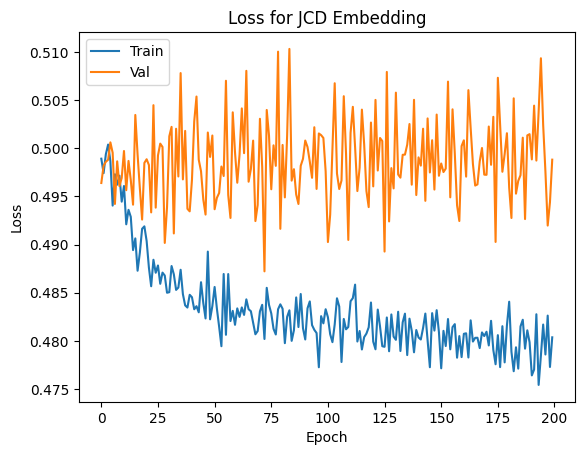

In [46]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss for JCD Embedding')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [17]:
filters = 64

def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x

def d1D(x,filters):
    x = Dense(filters,use_bias=True)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

# Get the embedding module from the trained Siamese network
embedding_moduleX_0 = siameseModelX_0.siameseNetwork.get_layer("embedding")
embedding_moduleX_1_Fast = siameseModelX_1_Fast.siameseNetwork.get_layer("embedding")
embedding_moduleX_1_Slow = siameseModelX_1_Slow.siameseNetwork.get_layer("embedding")

# Freeze the weights of the embedding module
for layer in embedding_moduleX_0.layers:
    layer.trainable = True
    
# Freeze the weights of the embedding module
for layer in embedding_moduleX_1_Fast.layers:
    layer.trainable = True

# Freeze the weights of the embedding module
for layer in embedding_moduleX_1_Slow.layers:
    layer.trainable = True

In [18]:
# embedding_moduleX_0 = siameseModelX_0.siameseNetworkX_0.get_layer("embedding")
# embedding_moduleX_1_Fast = siameseModelX_1_Fast.siameseNetworkX_1_Fast.get_layer("embedding")
# embedding_moduleX_1_Slow = siameseModelX_1_Slow.siameseNetworkX_1_Slow.get_layer("embedding")

# Create a new input layer for the classifier
M = Input(shape=(32,231))
P = Input(shape=(32,22,3))

embedding_moduleX_0.name = 'embedding1'
embedding_moduleX_1_Fast.name = 'embedding2'
embedding_moduleX_1_Slow.name = 'embedding3'

embeddingsX_0 = embedding_moduleX_0(M)
embeddingsX_1_Fast = embedding_moduleX_1_Fast(P)
embeddingsX_1_Slow = embedding_moduleX_1_Slow(P)

reshaped_embeddingsX_0 = Reshape((16, 16))(embeddingsX_0)
reshaped_embeddingsX_1_Fast = Reshape((16, 16))(embeddingsX_1_Fast)
reshaped_embeddingsX_1_Slow = Reshape((16, 16))(embeddingsX_1_Slow)

x = concatenate([reshaped_embeddingsX_0,reshaped_embeddingsX_1_Fast,reshaped_embeddingsX_1_Slow])

x = block(x, filters*2)
x = MaxPool1D(2)(x)
x = SpatialDropout1D(0.1)(x)

x = block(x, filters*4)
x = MaxPool1D(2)(x)
x = SpatialDropout1D(0.1)(x)

x = block(x, filters*8)
x = SpatialDropout1D(0.1)(x)

x = GlobalMaxPool1D()(x)

x = d1D(x, 128)
x = Dropout(0.5)(x)
x = d1D(x, 128)
x = Dropout(0.5)(x)

# Output layer
output_layer = Dense(14, activation='softmax')(x)

# Create the new model with the embedding module and classification head
classifier_model = keras.Model(inputs=[M,P], outputs=output_layer)

# Compile the classifier model
classifier_model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)

history = classifier_model.fit([X_0,X_1],Y,
            batch_size=32,
            epochs=400,
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)
            )

history = classifier_model.fit([X_0,X_1],Y,
            batch_size=32,
            epochs=500,
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)
            )

Epoch 1/400
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1130 - loss: 3.2703

W0000 00:00:1715338847.605135      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715338847.606119      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715338847.606940      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.1588 - loss: 2.9598

W0000 00:00:1715338879.750605      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715338879.751685      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715338879.752620      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715338881.758492      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 74s 581ms/step - accuracy: 0.1597 - loss: 2.9544 - val_accuracy: 0.0655 - val_loss: 2.8078 - learning_rate: 1.0000e-04
Epoch 2/400
11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3853 - loss: 1.9378

W0000 00:00:1715338883.030834      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4260 - loss: 1.8307 - val_accuracy: 0.1214 - val_loss: 3.2404 - learning_rate: 1.0000e-04
Epoch 3/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5761 - loss: 1.3336 - val_accuracy: 0.0607 - val_loss: 3.8114 - learning_rate: 1.0000e-04
Epoch 4/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6565 - loss: 1.0766 - val_accuracy: 0.0702 - val_loss: 3.9500 - learning_rate: 1.0000e-04
Epoch 5/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7477 - loss: 0.8939 - val_accuracy: 0.1000 - val_loss: 3.8972 - learning_rate: 1.0000e-04
Epoch 6/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8045 - loss: 0.7167 - val_accuracy: 0.1429 - val_loss: 3.1560 - learning_rate: 1.0000e-04
Epoch 7/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8090 - loss: 0.6639 - val_accuracy: 0.3238 - val_loss: 2.1179 - learning_rate: 1.0000e-04
Epoch 8/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8521 - loss: 0.5

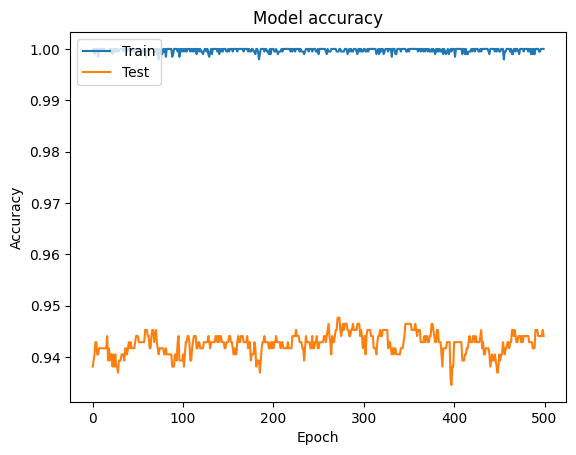

In [19]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

W0000 00:00:1715339419.784302      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step


W0000 00:00:1715339421.329889      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


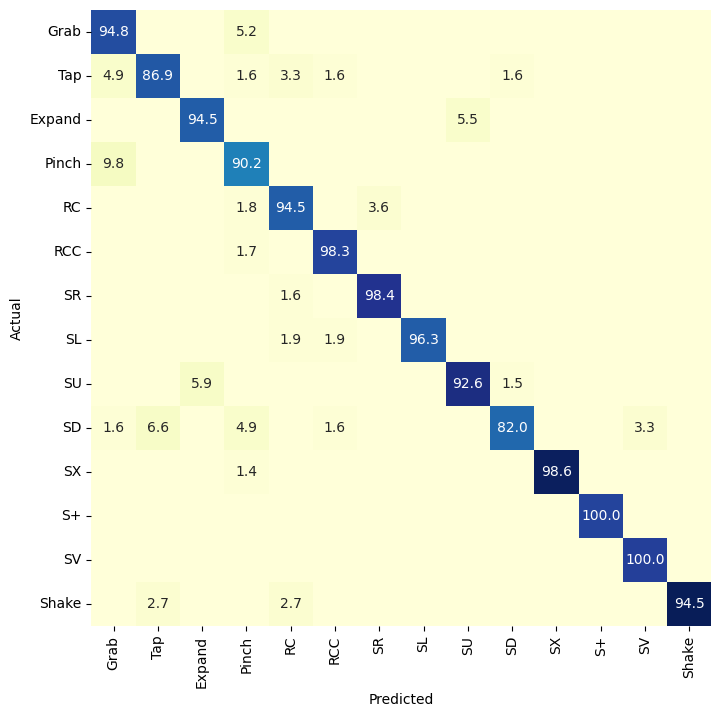

In [20]:
Y_pred = classifier_model.predict([X_test_0,X_test_1])
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

cm_analysis(y_true,y_pred, 'SHREC_14.png', labels, ymap=None, figsize=(8,8))

In [ ]:
misclassified_taps = []

for true_label, pred_label, tap_data in zip(y_true, y_pred, X_test_1):
    if true_label == 'Tap' and true_label != pred_label:
        misclassified_taps.append((tap_data))
        
misclassified_taps = np.stack(misclassified_taps)

In [ ]:
!pip install mediapipe

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mediapipe import solutions
from IPython import display

In [ ]:
def plot_landmarks_in_3d_with_edges(detection_result):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x_coordinates = [landmark[0] for landmark in detection_result]
    y_coordinates = [landmark[1] for landmark in detection_result]
    z_coordinates = [landmark[2] for landmark in detection_result]

    # Draw the hand landmarks in 3D.
    ax.scatter(x_coordinates, y_coordinates, z_coordinates)

    # Join required edges
    connections = solutions.hands.HAND_CONNECTIONS
    for connection in connections:
        start_index = connection[0]
        end_index = connection[1]
        ax.plot([x_coordinates[start_index], x_coordinates[end_index]],
                [y_coordinates[start_index], y_coordinates[end_index]],
                [z_coordinates[start_index], z_coordinates[end_index]],
                    color='b')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

def plot_landmarks_in_3d_with_edges(detection_result, frame):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x_coordinates = [landmark[0] for landmark in detection_result]
    y_coordinates = [landmark[1] for landmark in detection_result]
    z_coordinates = [landmark[2] for landmark in detection_result]

    # Draw the hand landmarks in 3D.
    ax.scatter(x_coordinates, y_coordinates, z_coordinates)

    # Join required edges
    connections = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8], [0, 9], [9, 10], 
                   [10, 11], [11, 12], [0, 13], [13, 14], [14, 15], [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]]
    for connection in connections:
        start_index = connection[0]
        end_index = connection[1]
        ax.plot([x_coordinates[start_index], x_coordinates[end_index]],
                [y_coordinates[start_index], y_coordinates[end_index]],
                [z_coordinates[start_index], z_coordinates[end_index]],
                    color='b')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Frame {}'.format(frame))

    return fig

# Generate some random data for demonstration
num_frames = 10
detection_results = [np.random.rand(21, 3) * 10 for _ in range(num_frames)]

# Create the animation
fig, ax = plt.subplots()
def update(frame):
    ax.clear()
    plot_landmarks_in_3d_with_edges(detection_results[frame], frame)

ani = FuncAnimation(fig, update, frames=num_frames, repeat=False)

# Save the animation as a movie
ani.save('3d_landmarks_with_edges.mp4', writer='ffmpeg', fps=2)
plt.close()


In [ ]:
# Create the animation
fig, ax = plt.subplots()
def update(frame):
    ax.clear()
    plot_landmarks_in_3d_with_edges(detection_results[frame], frame)

for i in range(len(misclassified_taps)):
    misclassified_taps[i]
    
ani = FuncAnimation(fig, update, frames=num_frames, repeat=False)

# Save the animation as a movie
ani.save('3d_landmarks_with_edges.mp4', writer='ffmpeg', fps=2)
plt.close()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

def plot_landmarks_in_3d_with_edges(detection_result, frame):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x_coordinates = [landmark[0] for landmark in detection_result]
    y_coordinates = [landmark[1] for landmark in detection_result]
    z_coordinates = [landmark[2] for landmark in detection_result]

    # Draw the hand landmarks in 3D.
    ax.scatter(x_coordinates, y_coordinates, z_coordinates)

    # Join required edges
    connections = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8], [0, 9], [9, 10], 
                   [10, 11], [11, 12], [0, 13], [13, 14], [14, 15], [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]]
    for connection in connections:
        start_index = connection[0]
        end_index = connection[1]
        ax.plot([x_coordinates[start_index], x_coordinates[end_index]],
                [y_coordinates[start_index], y_coordinates[end_index]],
                [z_coordinates[start_index], z_coordinates[end_index]],
                    color='b')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Frame {}'.format(frame))

    return fig

# Create a separate video for each misclassified tap example
for i, tap_example in enumerate(misclassified_taps):
    fig, ax = plt.subplots()
    def update(frame):
        ax.clear()
        plot_landmarks_in_3d_with_edges(tap_example[frame], frame)

    ani = FuncAnimation(fig, update, frames=32, repeat=False)

    # Save the animation as a movie
    filename = 'misclassified_tap_{}.mp4'.format(i)
    ani.save(filename, writer='ffmpeg', fps=2)
    plt.close()